# Импорты

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd drive/MyDrive/Курсовая

/content/drive/MyDrive/Курсовая


In [ ]:
import random, os
import numpy as np
import torch
import re
import pandas as pd

from sklearn.model_selection import train_test_split
from wordcloud import WordCloud
import matplotlib.pyplot as plt

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
# для воспроизводимости
def seed_everything(seed: int):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(42)

# Обработка твитов, разделение данных на train/val/test и сохранение

In [ ]:
# читаем весь датасет
df = pd.read_csv('training.1600000.processed.noemoticon.csv', encoding = "latin", header=None)

In [ ]:
# дадим названия колонкам и оставим только те, что нам нужны
df.columns = ['target', 'tweet_id', 'date', 'flag_query', 'user', 'tweet']
df = df.drop(columns=['tweet_id', 'date', 'flag_query'])

In [ ]:
# оставим только 100.000 записей, соответствующих пользователям с наибольшим количеством твитов
size = 100000

user_count = df.groupby(['user']).count()['target'].sort_values().cumsum()
user_names = user_count[user_count >= len(df) - size].index

# если вдруг выбрали чуть больше 100.000
df = df[df["user"].isin(user_names)].sample(size, random_state=42)

In [ ]:
df

,target,user,tweet
340533,0,nessie_111,apparently it's gonna rain... will it hurry up...
920322,4,faithsonshyne,@deewalk I agree AUSTRALIA WILL LOVE @Matthe...
330274,0,SinnamonLove,@MadisonMitchell hahaha! That'd be great excep...
731197,0,jonasnessica,"@whiteyy93 Yeah, that's what happens to mine....."
1319063,4,thisgoeshere,@GabrielSaporta i think maybe you need to go t...
...,...,...,...
288051,0,staceemcfly,"lmfao just emptied the washer, cos money was f..."
1090399,4,soulboykirk,"Oh, b4 I 4get, ty ty and ty for all the kind #..."
892590,4,TraceyHewins,@nuttychris hopefully but somehow....I doubt it
1417933,4,pato_30stm,@echiebabe Thanks a lot hun! nice and what ar...


In [ ]:
# заменим таргет 4 на 1
df['target'].replace(4,1, inplace=True)

In [ ]:
# можно сказать, что классы сбалансированны
df['target'].value_counts()

target
1    61928
0    38072
Name: count, dtype: int64

In [ ]:
# далее будем обрабатывать тексты твитов

# приведем к нижнему регистру
df['tweet'] = df['tweet'].str.lower()
df['tweet'].head()

340533     apparently it's gonna rain... will it hurry up...
920322     @deewalk  i agree  australia will love @matthe...
330274     @madisonmitchell hahaha! that'd be great excep...
731197     @whiteyy93 yeah, that's what happens to mine.....
1319063    @gabrielsaporta i think maybe you need to go t...
Name: tweet, dtype: object

In [ ]:
# удалим ссылки
def remove_urls(text):
    return re.sub('https?:\/\/.*?[\s+]', ' ', text)

df['tweet'] = df['tweet'].apply(remove_urls)
df['tweet'].head()

340533     apparently it's gonna rain... will it hurry up...
920322     @deewalk  i agree  australia will love @matthe...
330274     @madisonmitchell hahaha! that'd be great excep...
731197     @whiteyy93 yeah, that's what happens to mine.....
1319063    @gabrielsaporta i think maybe you need to go t...
Name: tweet, dtype: object

In [ ]:
# удалим все части текста, не являющиеся словами или пробелами или @
# @ его удалим отдельно
df['tweet'] = df['tweet'].replace(to_replace=r'[^\w\s@]', value='', regex=True)
df['tweet'].head()

340533     apparently its gonna rain will it hurry up im ...
920322     @deewalk  i agree  australia will love @matthe...
330274     @madisonmitchell hahaha thatd be great except ...
731197     @whiteyy93 yeah thats what happens to minei ho...
1319063    @gabrielsaporta i think maybe you need to go t...
Name: tweet, dtype: object

In [ ]:
# удалим все выражени вида @username
df['tweet'] = df['tweet'].replace(to_replace=r'@\S+', value='', regex=True)
df['tweet'].head()

340533     apparently its gonna rain will it hurry up im ...
920322       i agree  australia will love  lets start a p...
330274      hahaha thatd be great except then hbo could s...
731197      yeah thats what happens to minei hope its not...
1319063     i think maybe you need to go to the store and...
Name: tweet, dtype: object

In [ ]:
# удалим числа
df['tweet'] = df['tweet'].replace(to_replace=r'\d', value='', regex=True)
df['tweet'].head()

340533     apparently its gonna rain will it hurry up im ...
920322       i agree  australia will love  lets start a p...
330274      hahaha thatd be great except then hbo could s...
731197      yeah thats what happens to minei hope its not...
1319063     i think maybe you need to go to the store and...
Name: tweet, dtype: object

In [ ]:
# токенизируем
df['tweet'] = df['tweet'].apply(word_tokenize)
df['tweet'].head()

340533     [apparently, its, gon, na, rain, will, it, hur...
920322     [i, agree, australia, will, love, lets, start,...
330274     [hahaha, thatd, be, great, except, then, hbo, ...
731197     [yeah, thats, what, happens, to, minei, hope, ...
1319063    [i, think, maybe, you, need, to, go, to, the, ...
Name: tweet, dtype: object

In [ ]:
# удалим стоп-слова
stop_words = set(stopwords.words("english"))

df['tweet'] = df['tweet'].apply(lambda tweet: [word for word in tweet if word not in stop_words])
df['tweet'].head()

340533     [apparently, gon, na, rain, hurry, im, bloody,...
920322     [agree, australia, love, lets, start, petition...
330274     [hahaha, thatd, great, except, hbo, could, sue...
731197     [yeah, thats, happens, minei, hope, becuase, a...
1319063    [think, maybe, need, go, store, buy, food, hit...
Name: tweet, dtype: object

In [ ]:
# лемматизация
lemmatizer = WordNetLemmatizer()

def lemmatize_tokens(words):
    def get_wordnet_pos(word):
        tag = nltk.pos_tag([word])[0][1][0].upper()
        tag_dict = {"J": wordnet.ADJ,
                    "N": wordnet.NOUN,
                    "V": wordnet.VERB,
                    "R": wordnet.ADV}
        return tag_dict.get(tag, wordnet.NOUN)

    lemmas = [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in words]

    return lemmas

df['tweet'] = df['tweet'].apply(lemmatize_tokens)
df['tweet'].head()

340533     [apparently, gon, na, rain, hurry, im, bloody,...
920322     [agree, australia, love, let, start, petition,...
330274     [hahaha, thatd, great, except, hbo, could, sue...
731197     [yeah, thats, happens, minei, hope, becuase, a...
1319063    [think, maybe, need, go, store, buy, food, hit...
Name: tweet, dtype: object

In [ ]:
# удалим твиты с нулевым количеством слов
df['count_of_words'] = df['tweet'].apply(len)
print('Количество твитов с нулевым количеством слов после обработки - ', len(df[df['count_of_words'] == 0]))

df.drop(index=df[df['count_of_words'] == 0].index, inplace=True)

Количество твитов с нулевым количеством слов после обработки -  465


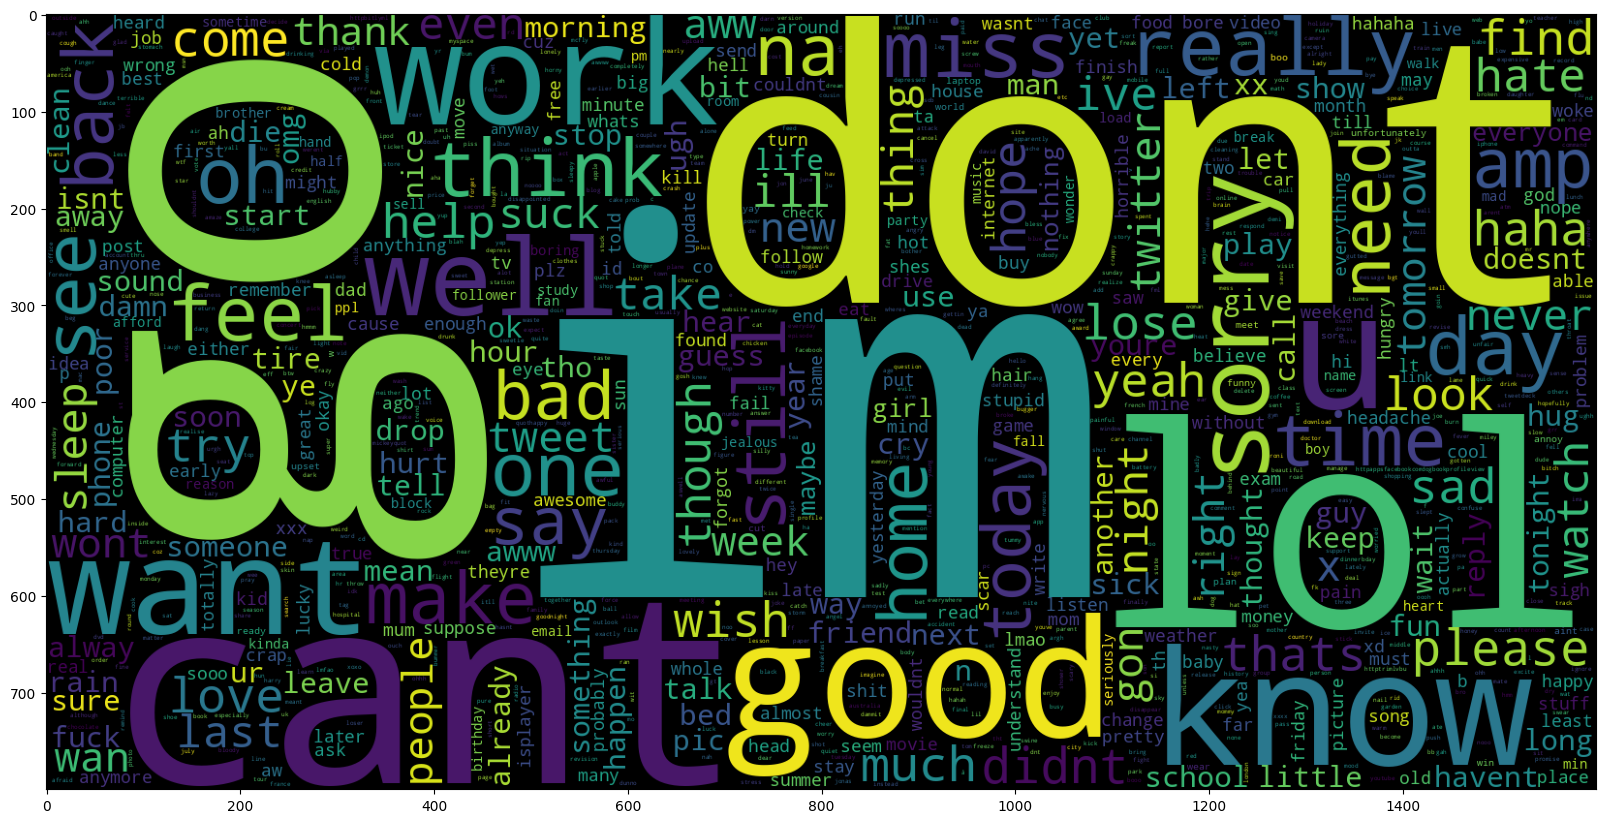

In [ ]:
# визуализируем облако слов для отрицательного и положительного класса

# отрицательный сентимент
data_neg = df['tweet'][df['target'] == 0]
plt.figure(figsize=(20, 20))
wc = WordCloud(max_words=1000, width=1600, height=800,
               collocations=False).generate(" ".join([word for lst in data_neg for word in lst]))
plt.imshow(wc)

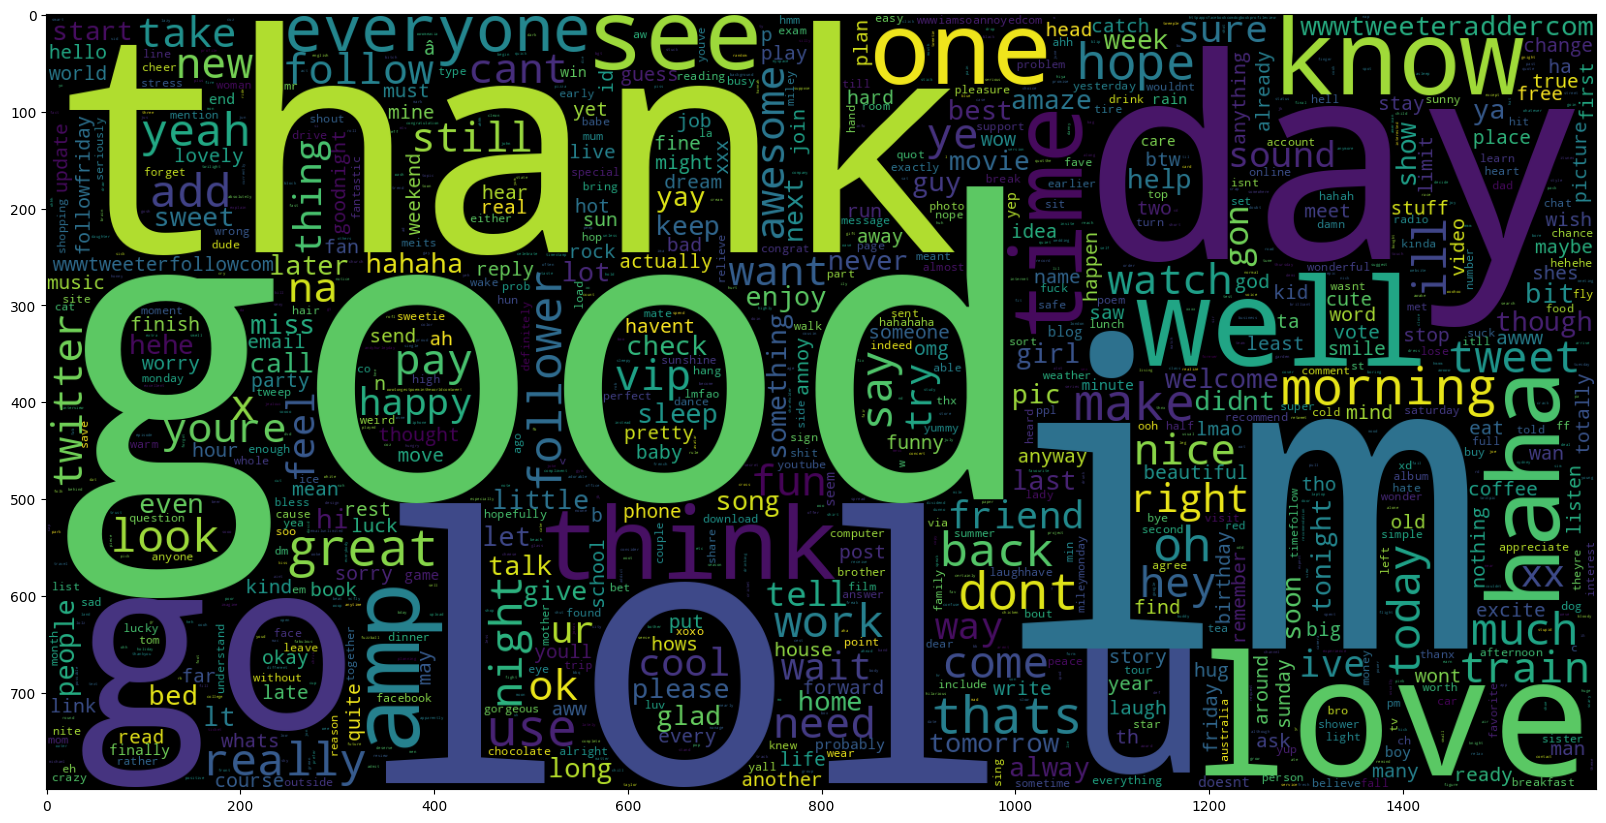

In [ ]:
# положительный сентимент
data_pos = df['tweet'][df['target'] == 1]
plt.figure(figsize=(20, 20))
wc = WordCloud(max_words=1000, width=1600, height=800,
               collocations=False).generate(" ".join([word for lst in data_pos for word in lst]))
plt.imshow(wc)

In [ ]:
# объединим слова в списках в одно предложение
df['tweet'] = df['tweet'].apply(lambda words: ' '.join(words))
df['tweet'].head()

340533     apparently gon na rain hurry im bloody hot atm...
920322           agree australia love let start petition lol
330274     hahaha thatd great except hbo could sue make s...
731197     yeah thats happens minei hope becuase au would...
1319063    think maybe need go store buy food hit bk get ...
Name: tweet, dtype: object

In [ ]:
# дропнем столбец с количеством слов, так как он уже не нужен
df.drop(columns=['count_of_words'], inplace=True)

In [ ]:
# разделим данные на train, val, test в отношении 70/10/20
X_train, X_test, y_train, y_test = train_test_split(df.index.values,
                                                    df.target.values,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify = df.target.values)

X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                  y_train,
                                                  test_size=0.125,
                                                  random_state=42,
                                                  stratify = y_train)

In [ ]:
# проверка
print('train ratio - ', 0.8 * (1 - 0.125))
print('val ratio - ', 0.8 * 0.125)

train ratio -  0.7000000000000001
val ratio -  0.1


In [ ]:
# сделаем столбец, который будет разделять данные
df.loc[X_train,'data_type'] = 'train'
df.loc[X_test,'data_type'] = 'test'
df.loc[X_val,'data_type'] = 'val'

In [ ]:
# рассмотрим распределение данных
df.groupby(['target','data_type']).count()

user  tweet
target data_type              
0      test        7580   7580
       train      26529  26529
       val         3790   3790
1      test       12327  12327
       train      43145  43145
       val         6164   6164

In [ ]:
# сохраним датасет
df.to_csv('sentiment140_100000.csv', index=False)